    age   d18O
0 -61.0 -52.06
1 -33.0 -52.41
2   6.0 -53.76
3  50.0 -55.42
4  66.0 -56.50
Index(['age', 'd18O'], dtype='object')


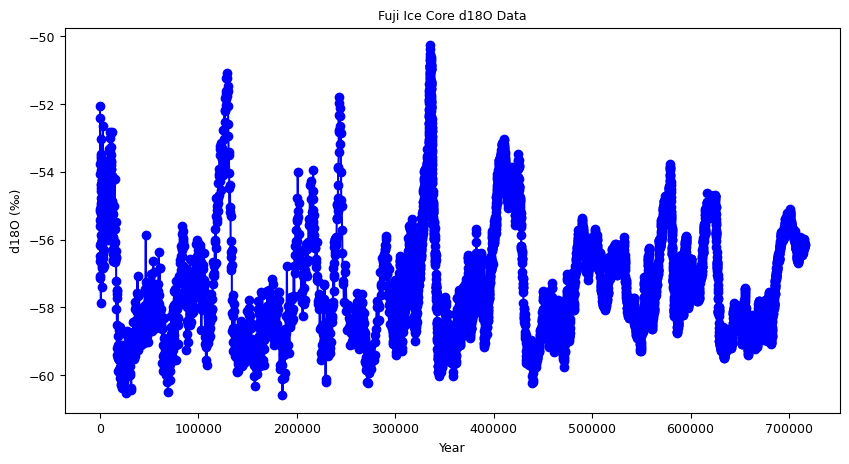

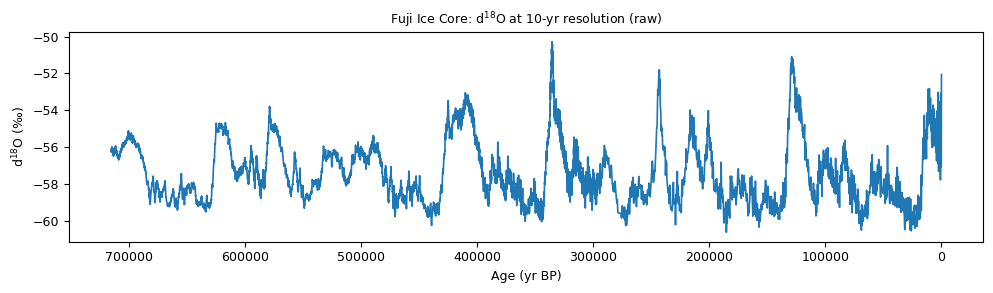

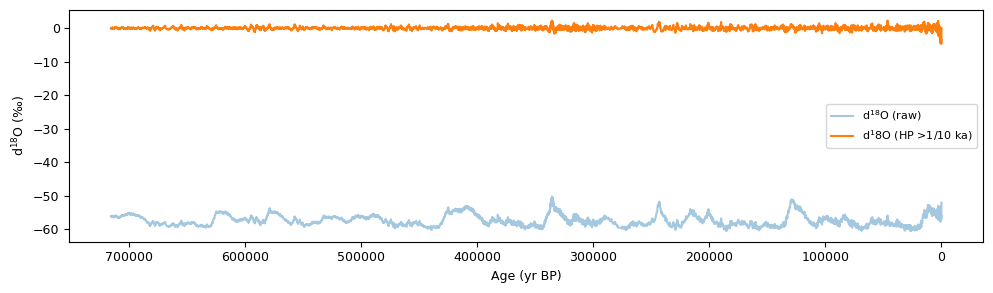

In [56]:
# Read the Fuji_d18O.xlsx file
import pandas as pd

file_path_fuji = r"D:\VScode\bipolar_seesaw_CCM\ice_core_data\Fuji_d18O.xlsx"
df_fuji = pd.read_excel(file_path_fuji)
print(df_fuji.head())
print(df_fuji.columns)

# drop nan
df_fuji = df_fuji.dropna()
# plot data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df_fuji['age'], df_fuji['d18O'], marker='o', linestyle='-', color='b')
plt.title('Fuji Ice Core d18O Data')
plt.xlabel('Year')
plt.ylabel('d18O (‰)')





import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


age_min = df_fuji['age'].min()
age_max = df_fuji['age'].max()
age_interp = np.arange(age_min, age_max + 1, 10)   # +1 to include the endpoint if it falls exactly

df_interp = pd.DataFrame({'age': age_interp})


df_fuji_sorted = df_fuji.sort_values('age')
df_interp['d18O'] = np.interp(
    df_interp['age'],
    df_fuji_sorted['age'].values,
    df_fuji_sorted['d18O'].values
)

# ── 4. (Optional) Quick sanity‐check plot of the interpolated series ──
plt.figure(figsize=(10, 3))
plt.plot(df_interp['age'], df_interp['d18O'], lw=1.2, color='tab:blue')
plt.xlabel('Age (yr BP)')
plt.ylabel('d$^{18}$O (‰)')
plt.title('Fuji Ice Core: d$^{18}$O at 10-yr resolution (raw)')
plt.gca().invert_xaxis()   # common in paleo to have older on the left
plt.tight_layout()
plt.show()

# ── 5. Set up Butterworth high‐pass filter parameters ──
dt = 10                               # sampling interval in years
cutoff_period = 10000                 # we want to remove variability longer than 10 000 yr
butter_order = 4

fs = 1.0 / dt                         # sampling frequency (samples per year)
fc = 1.0 / cutoff_period              # cutoff frequency in cycles per year
Wn = fc / (0.5 * fs)                  # normalized cutoff (to Nyquist)

b, a = butter(butter_order, Wn, btype='highpass')

# ── 6. Apply filtfilt → zero‐phase distortion ──
d18O_vals = df_interp['d18O'].values
filt_d18O = filtfilt(b, a, d18O_vals)

# ── 7. Wrap the result back into a DataFrame ──
df_filt = pd.DataFrame({
    'age': df_interp['age'].values,
    'd18O_hp': filt_d18O
})

# ── 8. (Optional) If you only want to plot ages younger than, say, 100 000 yr BP, crop:
#     (adjust “100000” to whatever cutoff you prefer)
max_age_plot = np.max(df_filt['age'])
mask = (df_filt['age'] <= max_age_plot)
df1 = df_interp[ df_interp['age'] <= max_age_plot ]
df2 = df_filt[ mask ]

# ── 9. Plot raw vs. high‐pass‐filtered on the same axes ──
plt.figure(figsize=(10, 3))
plt.plot(df1['age'], df1['d18O'],   alpha=0.4, label='d$^{18}$O (raw)')
plt.plot(df2['age'], df2['d18O_hp'], lw=1.5, label=f'd$^{18}$O (HP >1/{cutoff_period/1000:.0f} ka)')
plt.gca().invert_xaxis()
plt.xlabel('Age (yr BP)')
plt.ylabel('d$^{18}$O (‰)')
plt.legend()
plt.tight_layout()
plt.show()


df_filt_d18O= df_filt.copy()
# rename columns
df_filt_d18O.rename(columns={'d18O_hp': 'filt_d18O'}, inplace=True)

# crop the data for age >10000 and <=640000
df_filt_d18O = df_filt_d18O[(df_filt_d18O['age'] > 20000) & (df_filt_d18O['age'] <= 640000)]

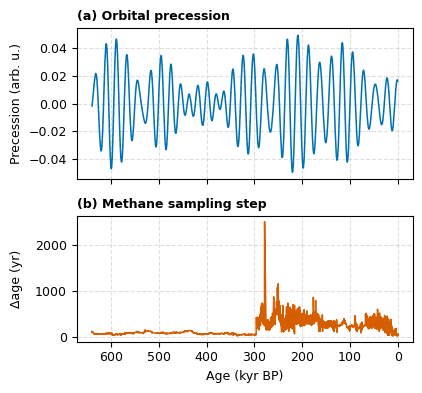

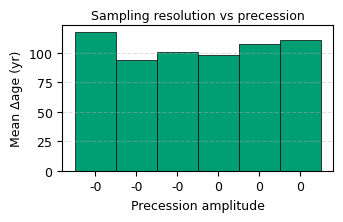

In [57]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

fig_pair, fig_bar = sa.age_gap_ana(
    df_fuji,
    age_min=0,
    age_max=640_000,
    pre_path=r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_800_inter100.txt",
    n_bins=6,
    tolerance=200
)



# TE from pre and obl to d18O MCV (dt=10)

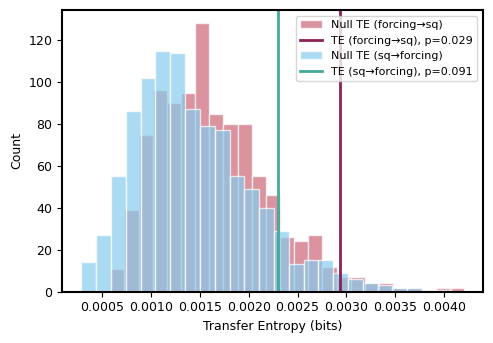

True


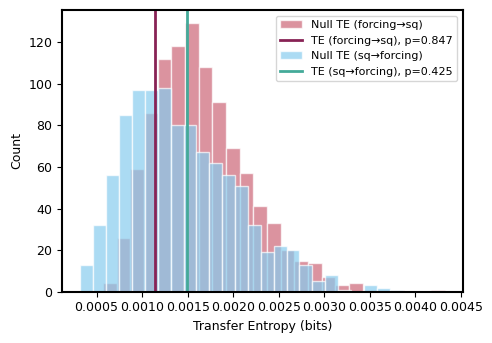

False


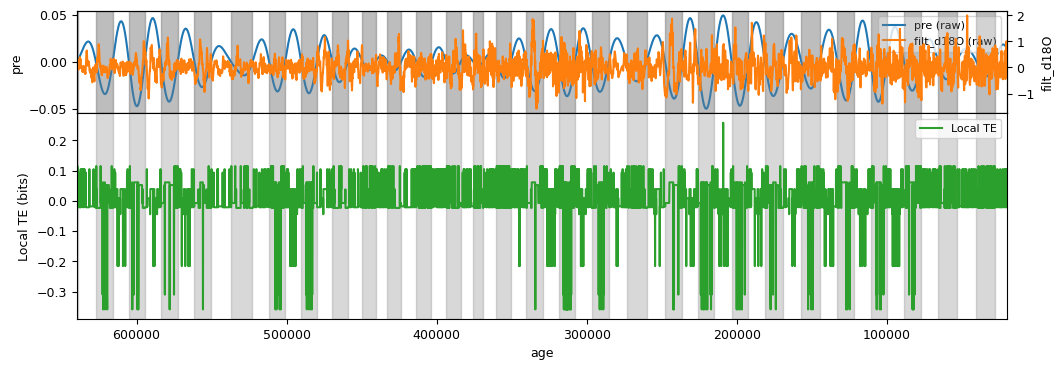

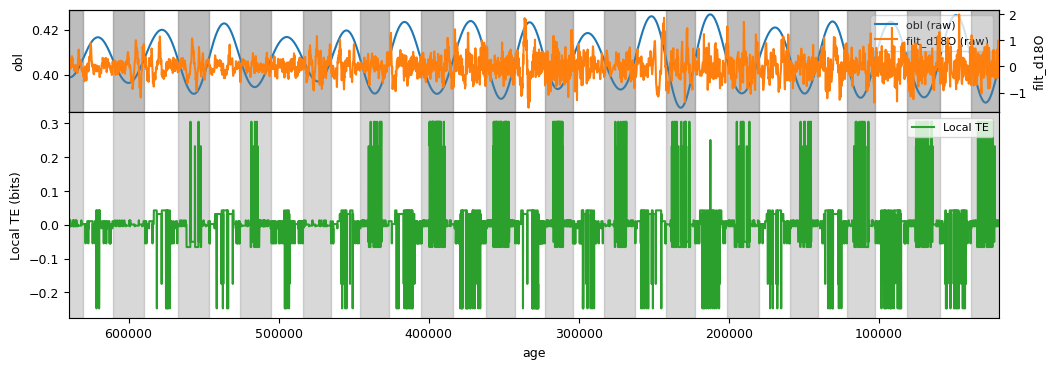

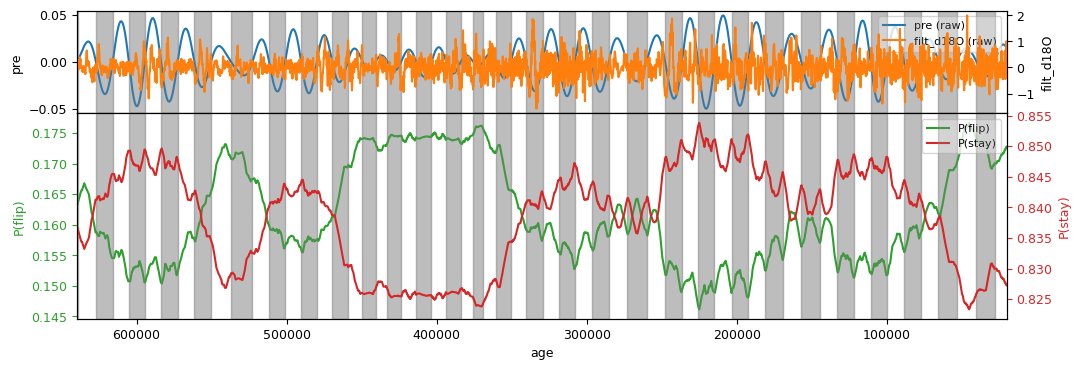

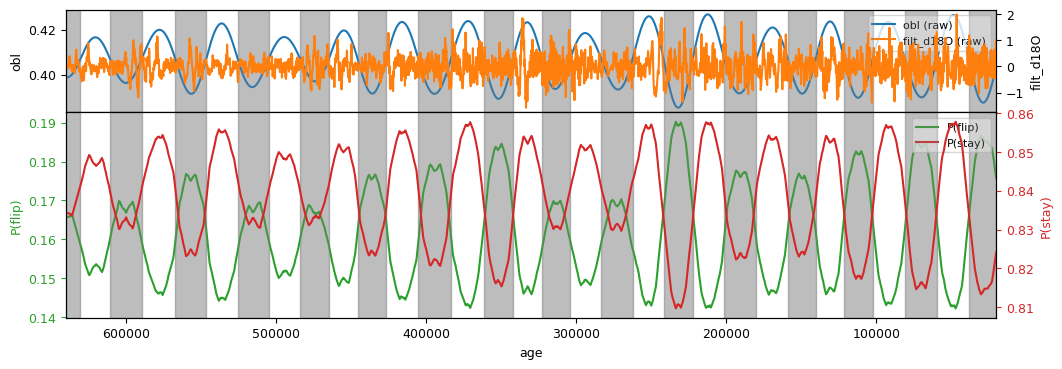

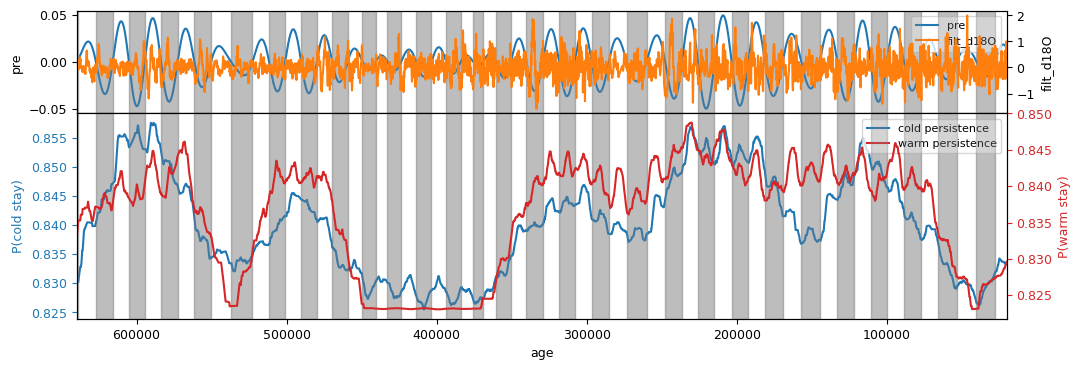

In [58]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 100, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)


result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, n_surr=1000)
print(result)


LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)




LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)



Lp = sa.local_prob(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)




Lp = sa.local_prob(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)


Lp = sa.local_stay_split(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)

# Where the TE comes from

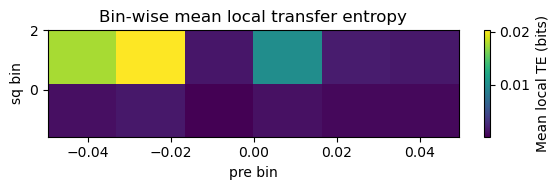

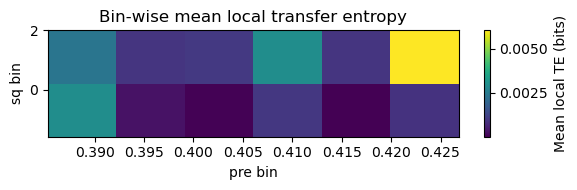

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


te_grid=sa.heatmap_binwise_local_te(
        pre=pre, sq=sq,
        pre_bins=6, sq_bins=2)

# te_grid=sa.heatmap_binwise_local_te(
#         pre=obl, sq=sq,
#         pre_bins=6, sq_bins=2)

# Frequency domain TE

max-power row = 54   →  period ≈ 23.0 ka


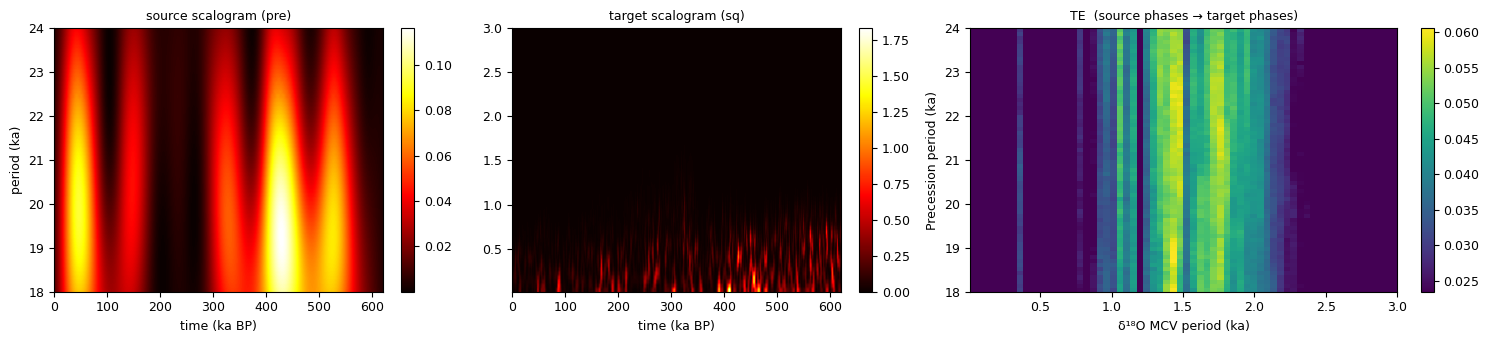

In [59]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

te_mat, p_src, p_trg = sa.freq_resolved_te(
    x = pre,             # forcing   (chronological order!)
    y = sq,              # response
    sampling_period = 100,     # yr/pt
    # source band: narrow around 20 ka
    src_min_period = 18_000,
    src_max_period = 24_000,
    n_src_scales   = 64,
    # target band: 0.1–3 ka
    trg_min_period = 10,
    trg_max_period = 3_000,
    n_trg_scales   = 64,
    k = 1,
    plot = True,
    source_vname='Precession',       # e.g. 'pre'
    target_vname='δ¹⁸O MCV'        # e.g. 'sq'
)

In [60]:
# from toolbox import sq_ana as sa 
# import importlib
# importlib.reload(sa)

# te_mat, p_src, p_trg = sa.freq_resolved_te(
#     x = obl,             # forcing   (chronological order!)
#     y = sq,              # response
#     sampling_period = 100,     # yr/pt
#     # source band: narrow around 20 ka
#     src_min_period = 35_000,
#     src_max_period = 50_000,
#     n_src_scales   = 64,
#     # target band: 0.1–3 ka
#     trg_min_period = 10,
#     trg_max_period = 3_000,
#     n_trg_scales   = 64,
#     k = 1,
#     plot = True,
#     source_vname='Obliquity',       # e.g. 'pre'
#     target_vname='δ¹⁸O MCV'        # e.g. 'sq'
# )

# P stay P flip analysis

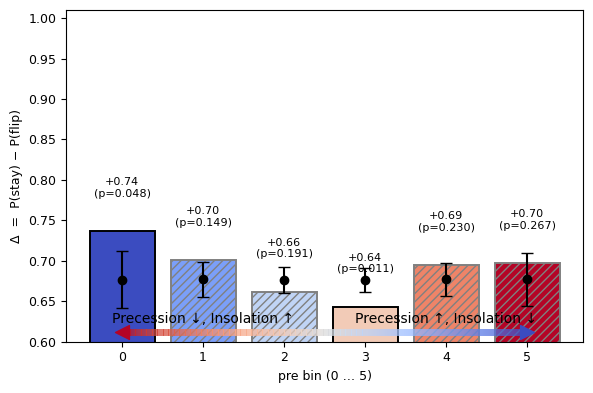

In [62]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_pre_i, df_sq_i,
        forcing_column='pre',
        target_column='filt_d18O',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        random_state=0   # reproducible
)


# delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
#         df_obl_i, df_sq_i,
#         forcing_column='obl',
#         target_column='filt_d18O',
#         nbins_pre=6,
#         n_surr=1000,
#         alpha=0.05,
#         random_state=0   # reproducible
# )


# P warm stay and P cold stay

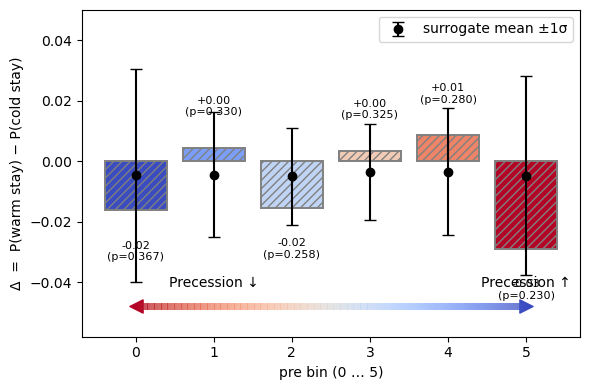

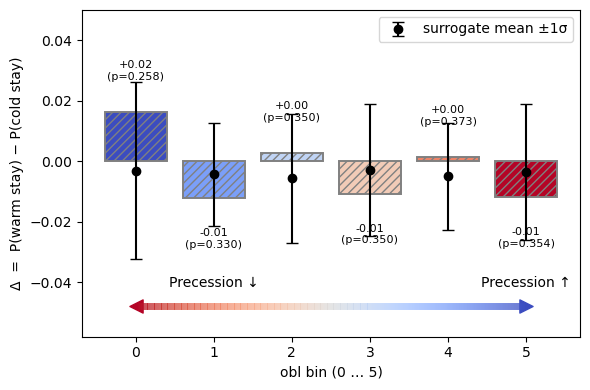

In [48]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

delta, mu, sd, p = sa.prob_prebins_staydiff_surr(
    df_pre      = df_pre_i,
    df_sq       = df_sq_i,
    forcing_column='pre',
    target_column='filt_d18O',
    nbins_pre   = 6,
    n_surr      = 1000,
    alpha       = 0.05,
    random_state=0
)
delta, mu, sd, p = sa.prob_prebins_staydiff_surr(
    df_pre      = df_obl_i,
    df_sq       = df_sq_i,
    forcing_column='obl',
    target_column='filt_d18O',
    nbins_pre   = 6,
    n_surr      = 1000,
    alpha       = 0.05,
    random_state=0
)

# The following are sensitivity tests

# Bin count

(62000,) (62000,) (62000,)
      pre=0  pre=1  pre=2  pre=3  pre=4  pre=5
sq=0   2195   5181   8402   8035   5099   2456
sq=1   2055   5039   7523   8400   5381   2234


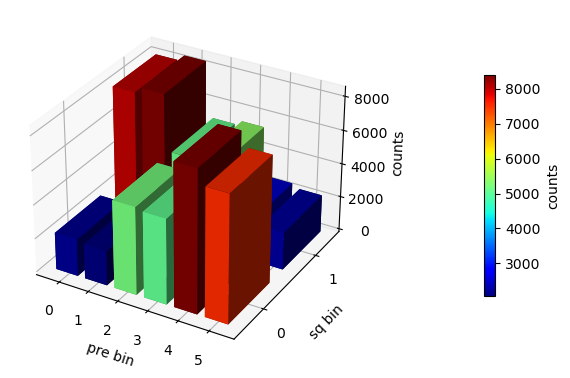

      pre=0  pre=1  pre=2  pre=3  pre=4  pre=5
sq=0   2716   7072   5129   5045   6678   4728
sq=1   3084   6463   5226   4675   6592   4592


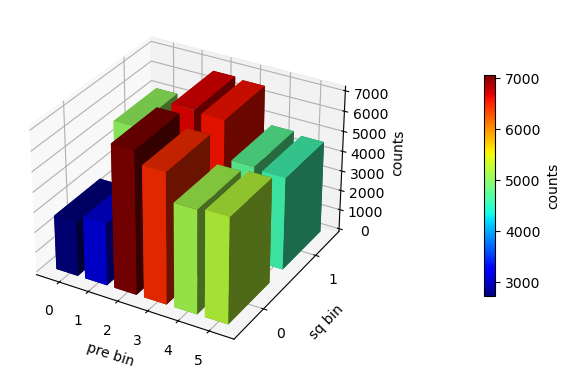

In [34]:
pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)

print(sq.shape, pre.shape, obl.shape)

from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

_ = sa.count_sq_pre_contexts_3d(sq, pre, nbins_pre=6)
_ = sa.count_sq_pre_contexts_3d(sq, obl, nbins_pre=6)

# Influence of noise: test on different pre bin numbers, length of history (k)

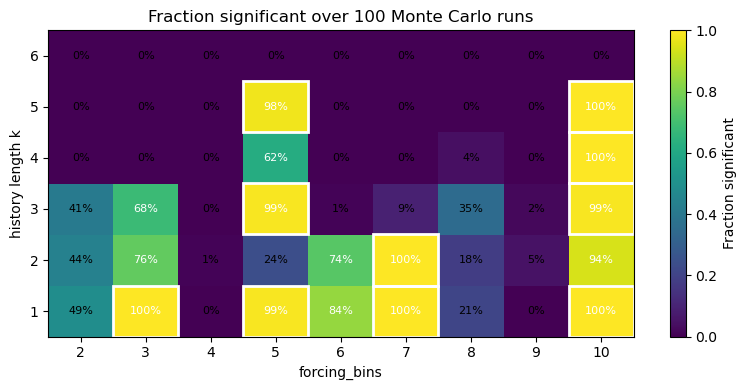

In [40]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)



df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 100, if_plot=False)


fractions= sa.mc_TE_heatmap(
    pre =df_pre_i['pre'].values,
    sq =df_sq_i['filt_d18O'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    plot=True)

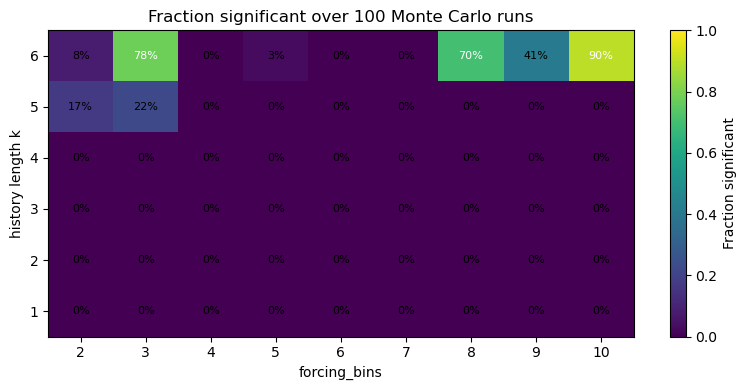

In [39]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 100, if_plot=False)

fractions= sa.mc_TE_heatmap(
    pre =df_obl_i['obl'].values,
    sq =df_sq_i['filt_d18O'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    plot=True)

# Influence of noise, test on different dt

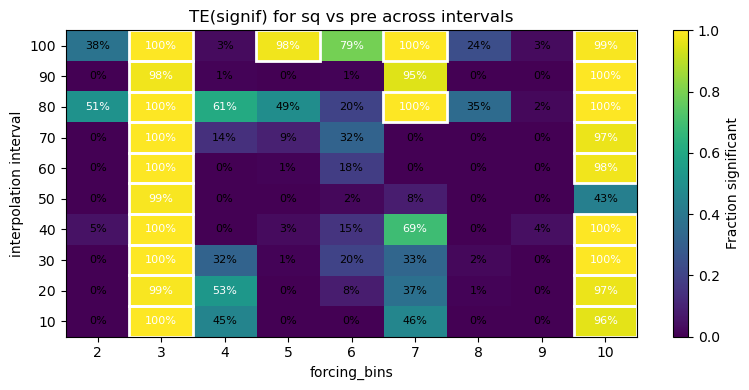

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


f=sa.mc_TE_heatmap_inter(
    df_filt_d18O.copy(),
    target_column='filt_d18O',
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    forcing_var='pre',
    plot=True
)

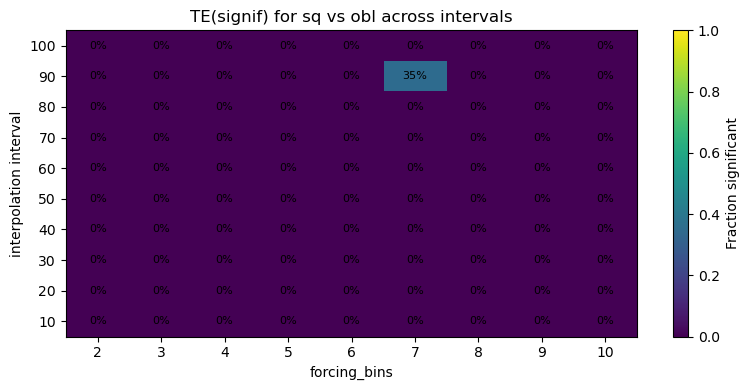

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)



f=sa.mc_TE_heatmap_inter(
    df_filt_d18O.copy(),
    target_column='filt_d18O',
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    forcing_var='obl',
    plot=True
)

# Influence of age scale uncertainty: random scaling experiment

In [17]:
import numpy as np
from toolbox import sq_ana as sa
import importlib
importlib.reload(sa)

# how many random trials?
N = 100

# your maximum age error (as ratio)
max_age_error = 10000
max_age_ratio = max_age_error / np.max(df_filt_d18O['age'].values)

# sigma so that ±2σ = ±max_age_ratio
sigma = max_age_ratio / 2.0

# counters
count_pre_sq = 0
count_obl_sq = 0

for _ in range(N):
    # draw a random ratio, truncated to [-max_age_ratio, +max_age_ratio]
    r = np.random.normal(0, sigma)
    r = np.clip(r, -max_age_ratio, max_age_ratio)
    
    # stretch your age axis
    df_sq_stretch = df_filt_d18O.copy()
    df_sq_stretch['age'] = df_sq_stretch['age'].values * (1.0 + r)
    
    # re-interpolate
    df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(
        df_sq_stretch, 20, if_plot=False
    )
    
    pre = df_pre_i['pre'].values
    obl = df_obl_i['obl'].values
    sq  = df_sq_i['filt_d18O'].values
    
    # test pre → sq
    result_pre, _ = sa.transfer_entropy_surrogate_test(
        pre, sq, forcing_bins=6, sq_bins=2, if_plot=False
    )
    if result_pre:
        count_pre_sq += 1
    
    # test obl → sq
    result_obl, _ = sa.transfer_entropy_surrogate_test(
        obl, sq, forcing_bins=6, sq_bins=2, if_plot=False
    )
    if result_obl:
        count_obl_sq += 1

# report
print(f"Out of {N} random age-errors:")
print(f"  pre → sq was significant in {count_pre_sq} runs")
print(f"  obl → sq was significant in {count_obl_sq} runs")


Out of 100 random age-errors:
  pre → sq was significant in 72 runs
  obl → sq was significant in 100 runs


# Influence of noise: random thining

In [20]:
import numpy as np
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)

def convergence_test(x, y, thinning_fractions, **te_kwargs):
    results = []
    N = len(x)
    for frac in thinning_fractions:
        m = int(N * frac)
        idx = np.sort(np.random.choice(N, m, replace=False))
        sig, te = sa.transfer_entropy_surrogate_test(
            x[idx], y[idx], if_plot=False, **te_kwargs
        )
        results.append((frac, sig))
    return results

fractions = np.linspace(0.2,1.0,5)   # 20%, 40%, …100%
print(convergence_test(pre, sq, fractions,
                       forcing_bins=6, sq_bins=2))

print(convergence_test(obl, sq, fractions,
                       forcing_bins=6, sq_bins=2))



[(0.2, False), (0.4, True), (0.6000000000000001, False), (0.8, True), (1.0, False)]
[(0.2, True), (0.4, True), (0.6000000000000001, True), (0.8, True), (1.0, True)]


# The influence of different bining plan ([max-min]/2; median; k-means)

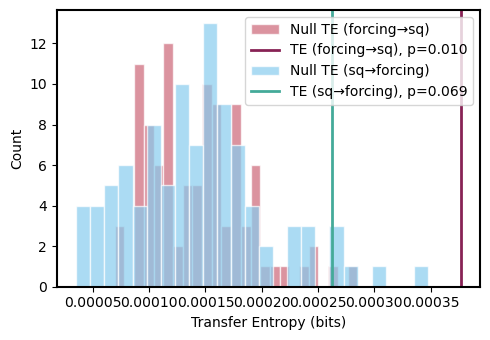

True


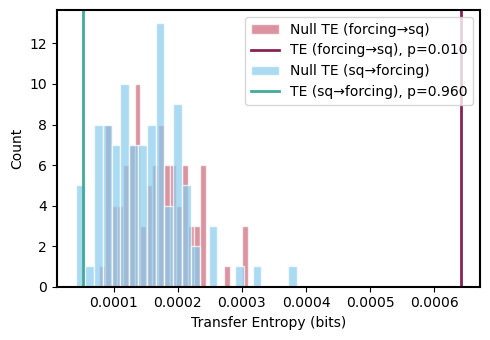

True


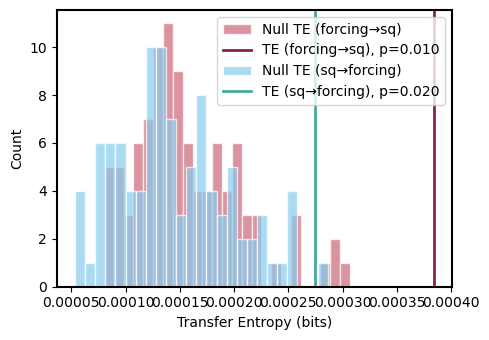

False


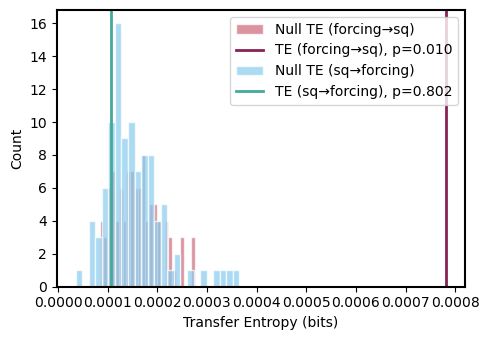

True


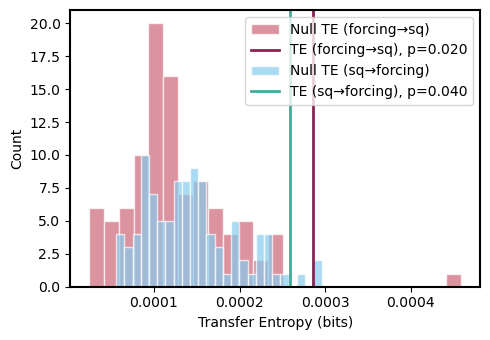

False


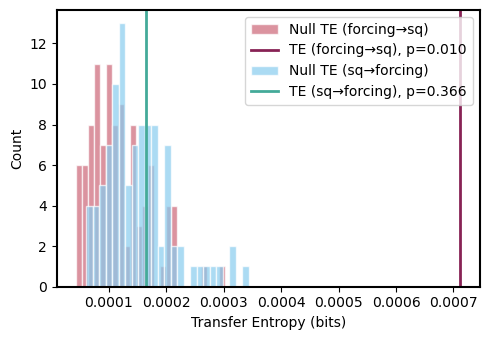

True


In [21]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


# sq_method='hist',  # options: 'hist', 'quantile', 'kmeans'

result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='hist')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='hist')
print(result)



result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='quantile')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='quantile')
print(result)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='kmeans')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='kmeans')
print(result)

# Influence of "echo" random shift experiment

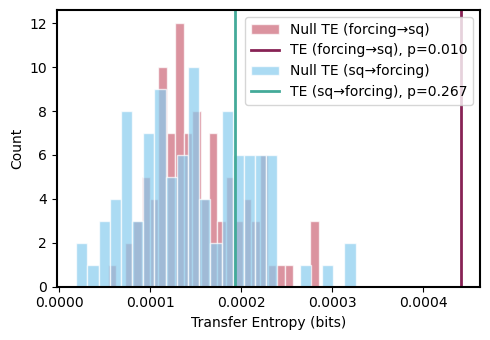

True


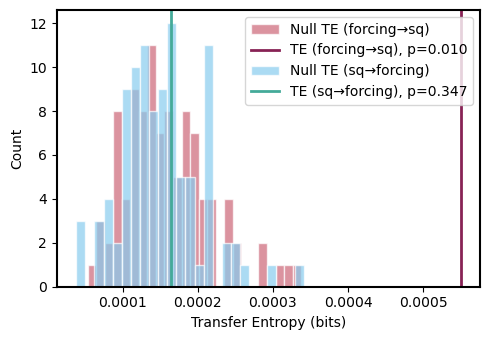

True


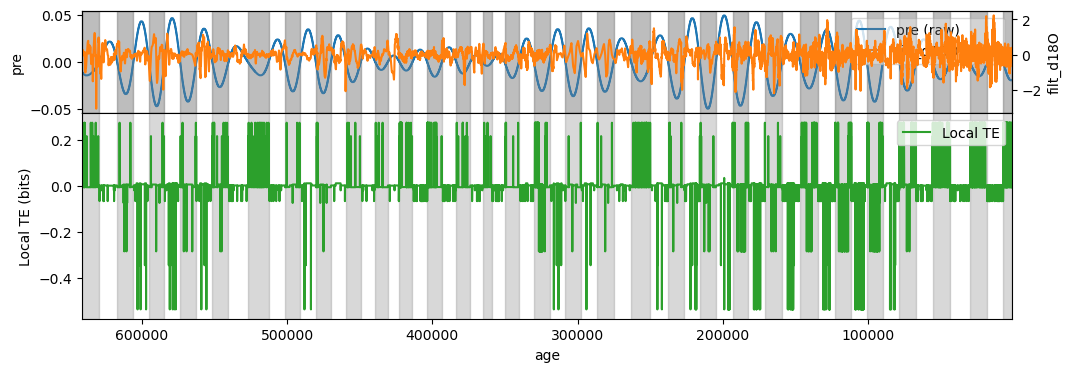

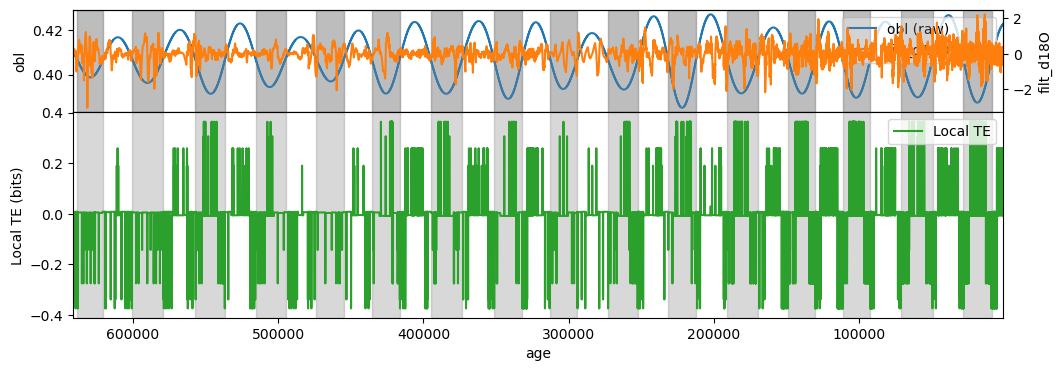

In [22]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.create_shift_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, n_surr=100)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)


result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, n_surr=100)
print(result)



LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)




LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

# Some other tests

# Check what the null Pre (random swap) looks like

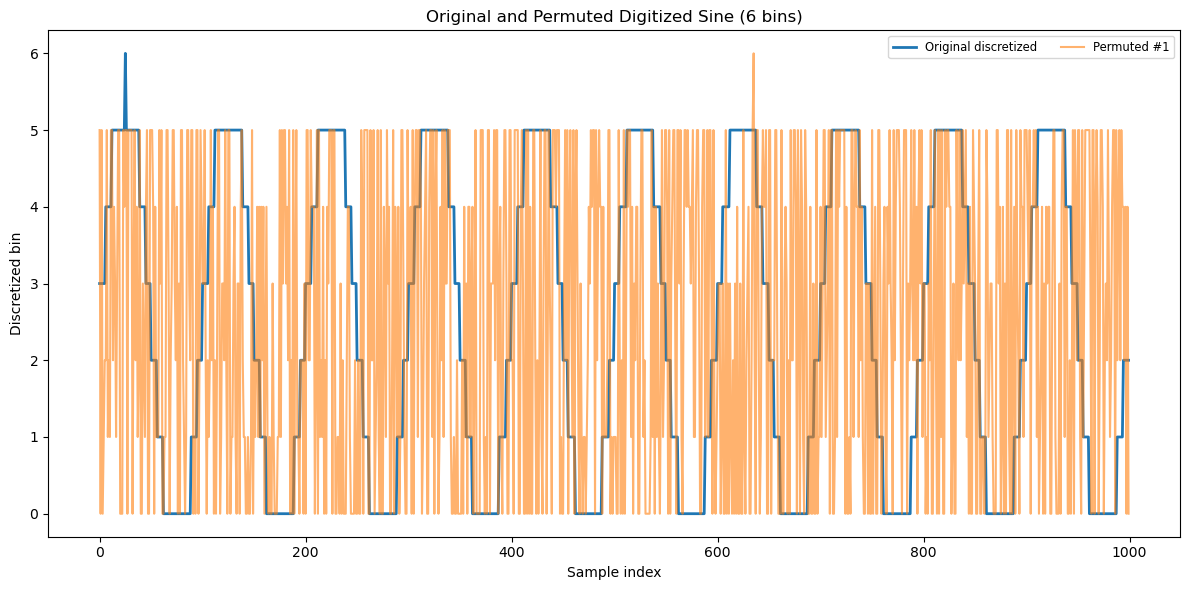

In [439]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sine wave with 10 cycles
cycles = 10
N = 1000
t = np.linspace(0, cycles * 2 * np.pi, N)
pre = np.sin(t)

# Discretize into 6 bins
edges = np.histogram_bin_edges(pre, bins=6)
pre_disc = np.digitize(pre, edges) - 1

# Generate 10 permuted surrogates
surrogates = [np.random.permutation(pre_disc) for _ in range(10)]

# Plot original and surrogates
plt.figure(figsize=(12, 6))
plt.plot(pre_disc, label='Original discretized', linewidth=2)
for i, s in enumerate(surrogates, 1):
    plt.plot(s, alpha=0.6, label=f'Permuted #{i}')
    if i == 1:
        break
plt.xlabel('Sample index')
plt.ylabel('Discretized bin')
plt.title('Original and Permuted Digitized Sine (6 bins)')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


# The d18O bins

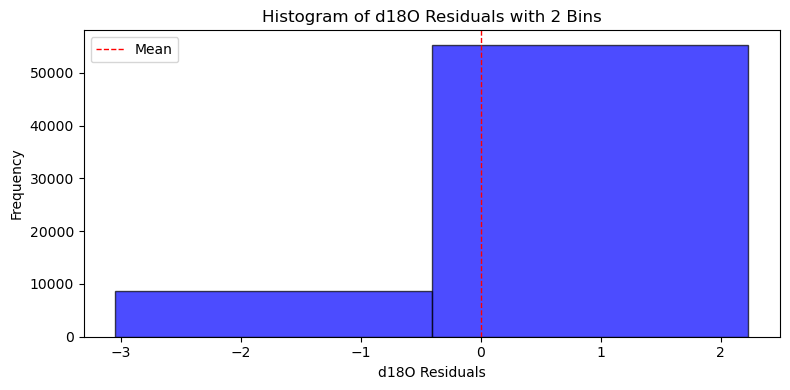

In [23]:
# plot the histogram of sq with bins=2
plt.figure(figsize=(8, 4))
plt.hist(sq, bins=2, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of d18O Residuals with 2 Bins')
plt.xlabel('d18O Residuals')
plt.ylabel('Frequency')
plt.axvline(np.mean(sq), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.legend()
plt.tight_layout()